<a href="https://colab.research.google.com/github/wildoctopus/pix2pixPytorchImpl/blob/main/pix2pixPytorchImpl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn.functional as F

In [3]:
#Mount data path from drive. 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Check mounted data "mianFile"
!cd /content/drive

#root path for mapdata  "/content/drive/My Drive/pix2pix";

In [4]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import vstack
from PIL import Image
import cv2
from numpy import savez_compressed

# load all images in a directory into memory


def load_images(path, size=(512, 256)):
    src_list, tar_list = list(), list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = cv2.imread(path + filename)
        pixels = cv2.resize(pixels, size)
        # print(pixels)
        #pixels = np.asarray(pixels)
        # split into satellite and map
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sat_img)
        tar_list.append(map_img)

    return src_list, tar_list


# dataset path
path = '/content/drive/My Drive/data/pix2pix/maps/train/'
# load dataset
src_images, tar_images = load_images(path)
# print('Loaded: ', src_images.shape, tar_images.shape)
# # save as compressed numpy array
# filename = 'maps_256.npz'
# savez_compressed(filename, src_images, tar_images)
# print('Saved dataset: ', filename)


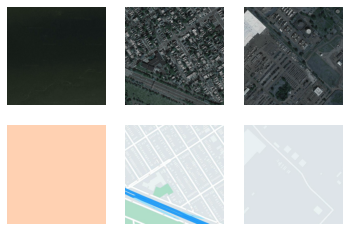

In [6]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset

n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [19]:
class MapDataset(Dataset):
    """MapDataset dataset."""

    def __init__(self, X_data, y_data, transform):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        X = transform(self.X_data[idx])
        #X = X.permute(2,0,1)
        Y = transform(self.y_data[idx])
        #Y = Y.permute(2,0,1)
        return X, Y

In [20]:
# data_loader
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

trainset = MapDataset(np.asarray(src_images), np.asarray(tar_images), transform)
trainloader = DataLoader(trainset, batch_size=1, shuffle=True)

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
# Discriminator Code
"""
PatchGAN is used as a Discriminator as defined in the paper - 
“Image-to-Image Translation with Conditional Adversarial Networks”

"""

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.dNet = nn.Sequential(
            # c1
            nn.Conv2d(6, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            # c2
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # c3
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # c4
            nn.Conv2d(256, 512, 4, 1, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            #Final output
            nn.Conv2d(512, 1, 4, 1, 1),
            nn.Sigmoid()

        )

    def forward(self, input, target):
      x = torch.cat([input, target], 1)
      #print(x.shape)
      return self.dNet(x)



In [11]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (dNet): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (12): Sigmoid()
  )
)


In [12]:
# Generator Code
"""
UNet is used as a Generator as defined in the paper - 
“Image-to-Image Translation with Conditional Adversarial Networks”

"""

class Generator(nn.Module):
    def __init__(self, d = 64):
        super(Generator, self).__init__()
        
        #UNet encoder
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d * 8)
        self.conv6 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(d * 8)
        self.conv7 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(d * 8)
        self.conv8 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        

        # Unet decoder
        self.deconv1 = nn.ConvTranspose2d(d * 8, d * 8, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 8)
        self.deconv3 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 8)
        self.deconv4 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d * 8)
        self.deconv5 = nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d * 4)
        self.deconv6 = nn.ConvTranspose2d(d * 4 * 2, d * 2, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(d * 2)
        self.deconv7 = nn.ConvTranspose2d(d * 2 * 2, d, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(d)
        self.deconv8 = nn.ConvTranspose2d(d * 2, 3, 4, 2, 1)

    # forward method
    def forward(self, input):
        e1 = self.conv1(input)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        e8 = self.conv8(F.leaky_relu(e7, 0.2))
        
        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e8))), 0.5, training=True)
        d1 = torch.cat([d1, e7], 1)
        d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d2, e6], 1)
        d3 = F.dropout(self.deconv3_bn(self.deconv3(F.relu(d2))), 0.5, training=True)
        d3 = torch.cat([d3, e5], 1)
        d4 = self.deconv4_bn(self.deconv4(F.relu(d3)))
        
        d4 = torch.cat([d4, e4], 1)
        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)
        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)
        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        d8 = self.deconv8(F.relu(d7))
        o = F.tanh(d8)

        return o

In [13]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv6_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(512, 512, kernel_size=(4, 

In [14]:
# loss
BCE_loss = nn.BCELoss().to(device)
L1_loss = nn.L1Loss().to(device)

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
#fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
lr = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [21]:
# Training Loop

# Lists to keep track of progress
num_epochs = 200
L1_lambda = 100
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (X, Y) in enumerate(trainloader, 0):

        D_losses = []
        G_losses = []

        ##############################
        # Train D with all-real batch
        ##############################

        netD.zero_grad()
        # Format batch
        x_ = X.to(device)
        y_ = Y.to(device)

        b_size = x_.size(0)

        labelR = torch.full((30, 30), real_label,
                            dtype=torch.float, device=device)
        labelF = torch.full((30, 30), fake_label,
                            dtype=torch.float, device=device)

        # Forward pass real batch through D
        outputD = netD(x_, y_).squeeze()
        # print(outputD.size())

        # Calculate loss on all-real batch
        D_real_loss = BCE_loss(outputD, labelR)

        G_result = netG(x_)
        D_result = netD(x_, G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, labelF)

        D_train_loss = (D_real_loss + D_fake_loss) * 0.5
        D_train_loss.backward()
        optimizerD.step()

        train_hist['D_losses'].append(D_train_loss.item())

        D_losses.append(D_train_loss.item())

        ############################
        # Train Generator
        ###########################

        netG.zero_grad()

        G_result = netG(x_)
        D_result = netD(x_, G_result).squeeze()

        G_train_loss = BCE_loss(D_result, labelR) + \
            L1_lambda * L1_loss(G_result, y_)
        G_train_loss.backward()
        optimizerG.step()

        train_hist['G_losses'].append(G_train_loss.item())

        G_losses.append(G_train_loss.item())

    print('[%d/%d] - loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), num_epochs, torch.mean(torch.FloatTensor(D_losses)),
                                                    torch.mean(torch.FloatTensor(G_losses))))


Starting Training Loop...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1/200] - loss_d: 0.769, loss_g: 12.299
[2/200] - loss_d: 0.590, loss_g: 6.510
[3/200] - loss_d: 0.486, loss_g: 6.549
[4/200] - loss_d: 0.711, loss_g: 7.279
[5/200] - loss_d: 0.208, loss_g: 11.451
[6/200] - loss_d: 0.103, loss_g: 21.102
[7/200] - loss_d: 1.152, loss_g: 11.194
[8/200] - loss_d: 0.176, loss_g: 8.912
[9/200] - loss_d: 0.018, loss_g: 12.898
[10/200] - loss_d: 0.200, loss_g: 9.080
[11/200] - loss_d: 0.078, loss_g: 14.190
[12/200] - loss_d: 0.372, loss_g: 11.131
[13/200] - loss_d: 0.193, loss_g: 7.827
[14/200] - loss_d: 0.368, loss_g: 21.322
[15/200] - loss_d: 0.266, loss_g: 9.055
[16/200] - loss_d: 0.049, loss_g: 13.077
[17/200] - loss_d: 0.187, loss_g: 14.356
[18/200] - loss_d: 0.611, loss_g: 7.432
[19/200] - loss_d: 0.365, loss_g: 7.074
[20/200] - loss_d: 0.128, loss_g: 10.184
[21/200] - loss_d: 0.039, loss_g: 10.580
[22/200] - loss_d: 0.874, loss_g: 9.377
[23/200] - loss_d: 0.389, loss_g: 8.794
[24/200] - loss_d: 0.074, loss_g: 8.768
[25/200] - loss_d: 0.460, loss_g: 10.

In [23]:

root = '/content/drive/My Drive/data/pix2pix/maps/'
print("Training finish!... save training results")
torch.save(netG.state_dict(), root + '/generator_param.pkl')
torch.save(netD.state_dict(), root + '/discriminator_param.pkl')


Training finish!... save training results
